<a href="https://colab.research.google.com/github/elinneaeriksson/TransportAI1/blob/main/Handin_2_Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and prepare data

In [1]:
import pandas as pd

# The path of the dataset
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_4_Text_classification/Pakistani%20Traffic%20sentiment%20Analysis.csv'

# Load the data use the pandas
df = pd.read_csv(url)

#Print data
print(df.head())

# Delete duplicates
df = df.drop_duplicates()

# Displaying the instances of each class
df.groupby('Sentiment').describe()

#Split df into Text and sentiment
x = df['Text']
y = df['Sentiment']

                                                Text  Sentiment
0                              Adayala road is clear          0
1  Traffic jam from parbat rd to nazim-ud-din rd ...          1
2                                    Mandra is clear          0
3                               Fort street is clear          0
4  Mashriq Hotel towards Fawara Chowk, City Sadda...          1


#Split test and training

In [2]:
from sklearn.model_selection import train_test_split

# Split the train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Test the best vectorizations and models


 Evaluating countVectorizer with Logistic model
{'model__C': 1}
The accuracy of the model is: 0.937799043062201

 Evaluating countVectorizer with KNN model
{'model__n_neighbors': 3, 'model__weights': 'uniform'}
The accuracy of the model is: 0.9473684210526315

 Evaluating countVectorizer with RF model
{'model__n_estimators': 300}
The accuracy of the model is: 0.9617224880382775

 Evaluating countVectorizer with XGBoost model
{'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 300}
The accuracy of the model is: 0.9593301435406698

 Evaluating countVectorizer with SVM model
{'model__C': 10, 'model__kernel': 'rbf'}
The accuracy of the model is: 0.9569377990430622

 Evaluating countVectorizer with Naive_Bayes model
{'model__alpha': 0.1, 'model__force_alpha': True}
The accuracy of the model is: 0.9425837320574163

 Evaluating hashingVectorizer with Logistic model
{'model__C': 10}
The accuracy of the model is: 0.9521531100478469

 Evaluating hashingVectorizer with KN

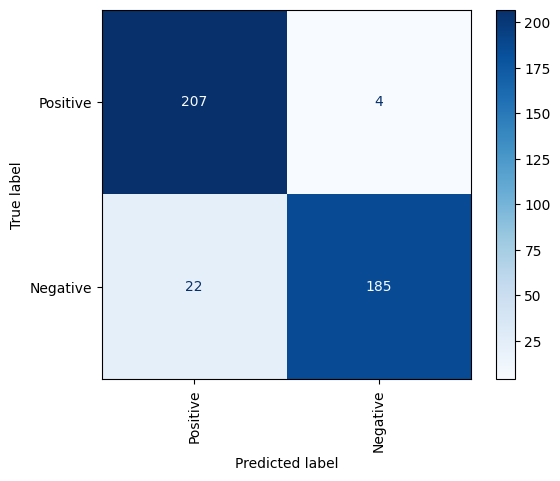

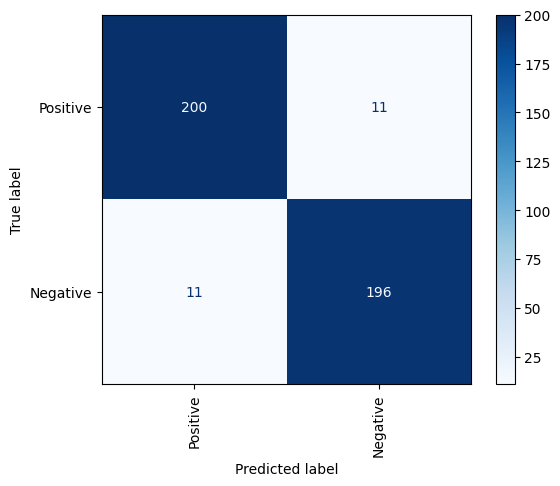

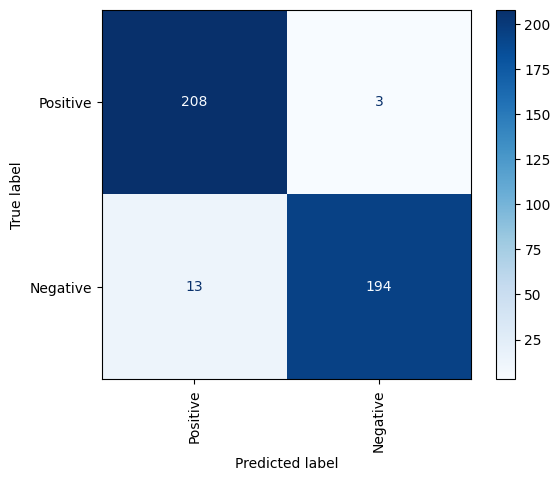

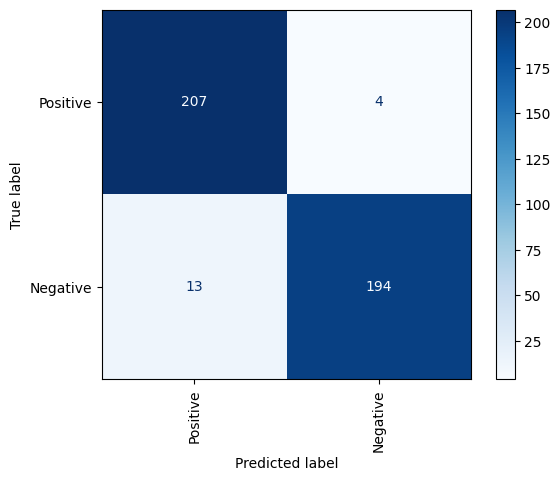

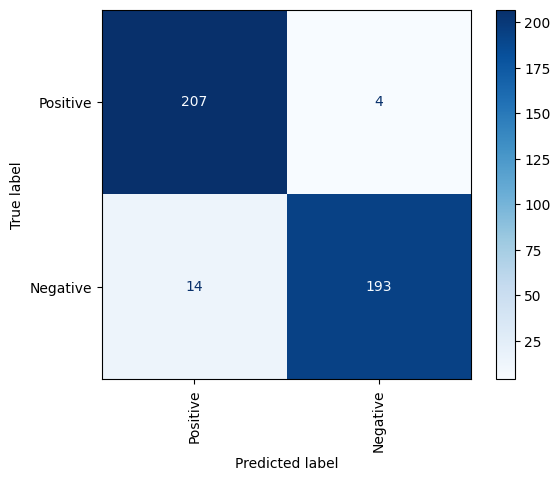

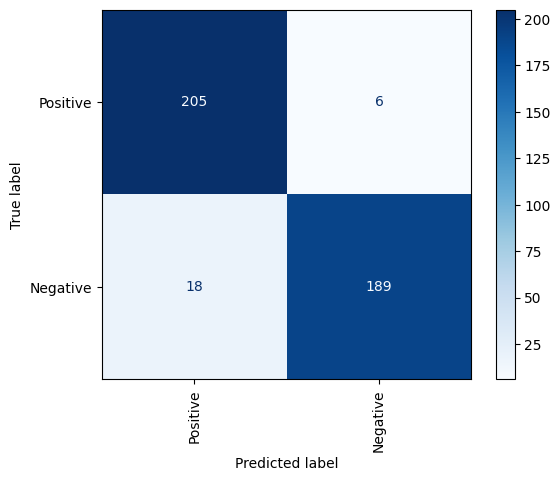

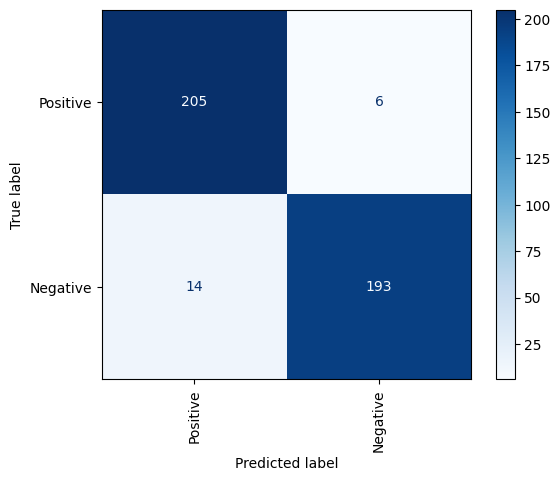

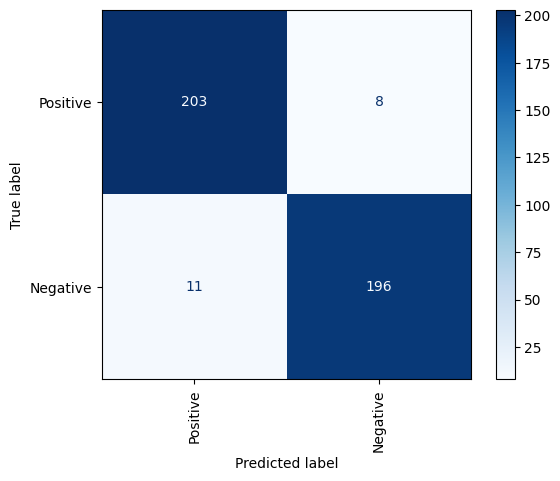

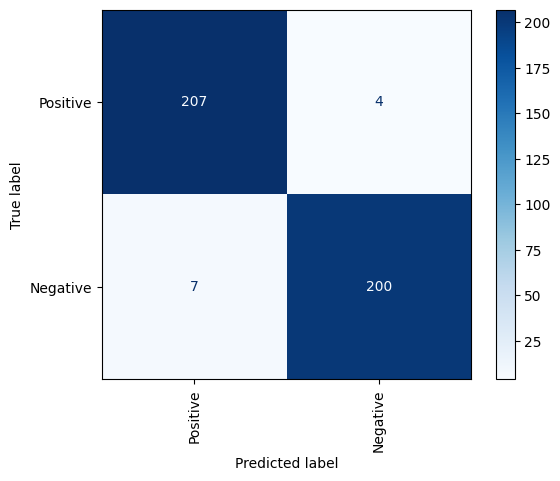

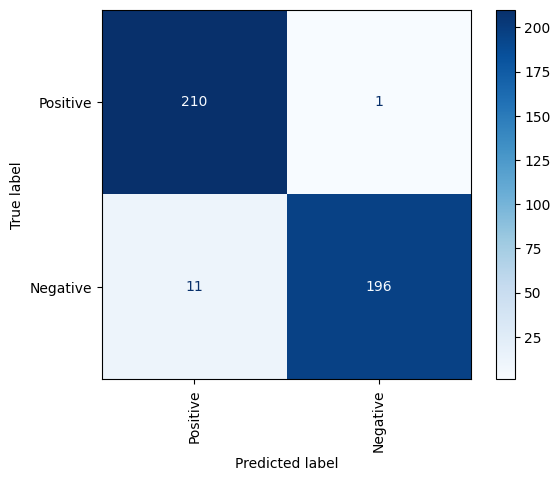

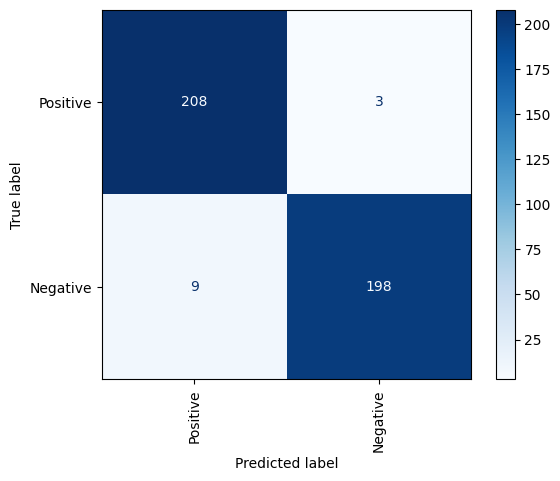

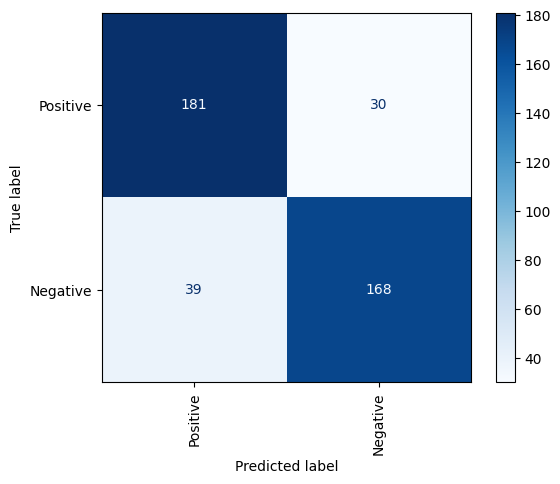

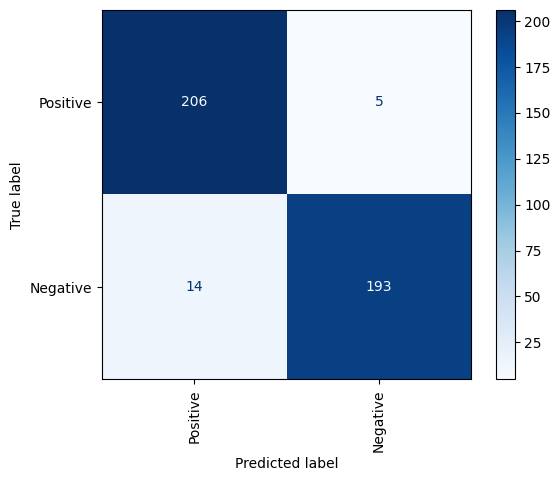

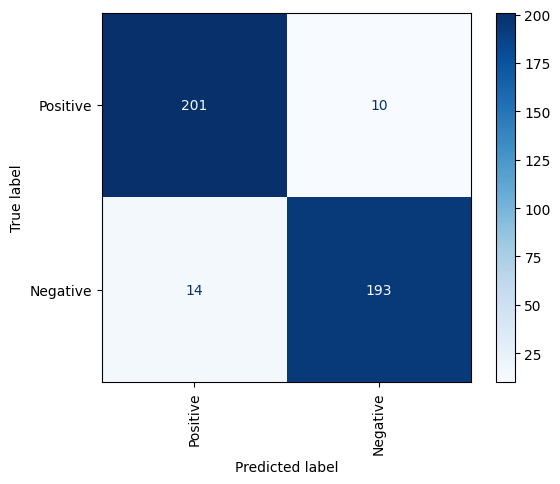

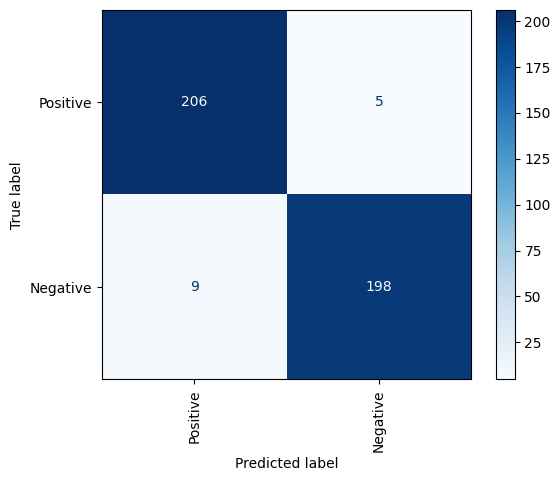

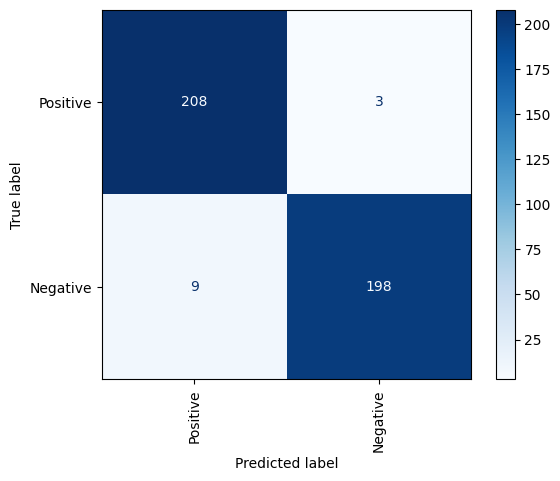

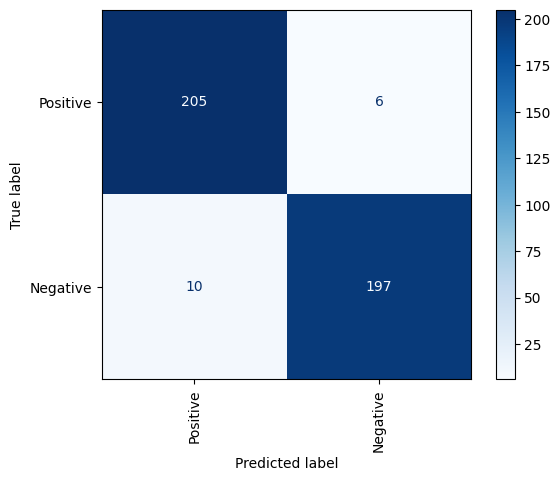

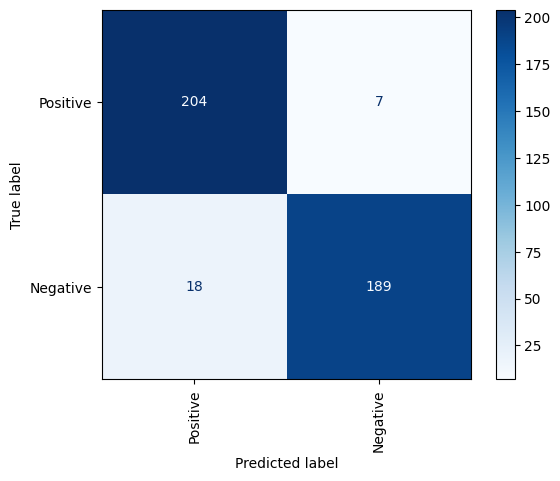

In [3]:
from sklearn.pipeline import Pipeline
import pandas as pd
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB


#define vectorizers in dict
vectorizers ={
'countVectorizer' : CountVectorizer(ngram_range=(1, 2), stop_words='english',min_df=20),
'hashingVectorizer': HashingVectorizer(ngram_range=(1, 2), n_features=200),
'tfidfVectorizer' :  TfidfVectorizer(min_df=20, norm='l2',smooth_idf=True, use_idf=True, ngram_range=(1, 1), stop_words='english'),}

#define models in a dict with name and a tuple with model and param_grid
models = {
    'Logistic': (LogisticRegression(max_iter=1000, random_state=0), {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'KNN': (KNeighborsClassifier(), {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}),
    #had to remove some parameters from RF since it took to long to run
    #'RF': (RandomForestClassifier(random_state=0), {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20, 30], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}),
    'RF': (RandomForestClassifier(random_state=0), {'model__n_estimators': [100, 200, 300]}),
    'XGBoost': (XGBClassifier(), {'model__learning_rate': [0.01, 0.1, 0.2], 'model__n_estimators': [100, 200, 300], 'model__max_depth': [3, 4, 5]}),
    'SVM': (SVC(probability=True), {'model__kernel': ['linear', 'rbf', 'poly'], 'model__C': [0.1, 1, 10]}),
    'Naive_Bayes': (BernoulliNB(), {'model__alpha': [0.1, 0.5, 1], 'model__force_alpha': [True, False]})}

#dataframe to store accuracies
accuracy_table = pd.DataFrame(index=vectorizers.keys(), columns=models.keys())

#for-loop to do hypertuning for all models
for vec_name, vectorizer in vectorizers.items():

    for model_name, (model, param_grid) in models.items():
        print(f"\n Evaluating {vec_name} with {model_name} model")

        # pipeline of vectorizer and model
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('model', model)])

        # Grid search to find best parameters using the pipeline
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(x_train, y_train)

        # Print best params
        best_params = grid_search.best_params_
        print(best_params)

        # Run on test set
        model = grid_search.best_estimator_
        accuracy = accuracy_score(y_test,model.predict(x_test))
        print('The accuracy of the model is: '+str(accuracy))

        #add to DF
        accuracy_table.loc[vec_name, model_name] = accuracy

        # plot confusion matrix
        cmd.from_estimator(
            grid_search.best_estimator_,
            x_test,
            y_test,
            display_labels=['Positive', 'Negative'],
            cmap='Blues',
            xticks_rotation='vertical')

In [5]:
#overview of accuracies to identify best model
display(accuracy_table)

,Logistic,KNN,RF,XGBoost,SVM,Naive_Bayes
countVectorizer,0.937799,0.947368,0.961722,0.95933,0.956938,0.942584
hashingVectorizer,0.952153,0.954545,0.973684,0.971292,0.971292,0.834928
tfidfVectorizer,0.954545,0.942584,0.966507,0.971292,0.961722,0.940191


###Model structure:

This lab tries different methods of text classification for sentiment analysis and compares their accuracy. The input data is a dataset with a "Text" column, containing positive and negative reviews of Pakistani traffic, and a "Sentiment" column stating whether it is a positive or negative review.

A grid search was performed for each combination of vectorizers and models. The accuracy scores are displayed below. Some parameters were altered for all models. The accuracy was validated by testing the model on 20% of the data (not used in training).

###Results:

The best accuracy (0.9737) was obtained using Random Forest with the Hashing vectorizer. XGBoost and SVM with the hashing vectorizer and XGBoost with the TFIDF Vectorizer all had accuracies above 0.97. The worst performance was with the hashing vectorizer and the Naive Bayes model.

###Reflection:

The accuracies score were high overall, showing that the text classifications worked well for these datasets. Even more model parameters could have been altered in the hyperparameter tuning. It could also improve the accuracy to change the n-grams of the vectorizations (allowing more consecutive words to be treated as one word) (Proise 2022).

Text classification can be useful in transport planning when creating models of delay or choice models, or understanding answers in cutomer surveys.

###References:

Jeff Prosise, Applied Machine Learning and AI for Engineers, 2022.